라이브러리 임포트 완료!
데이터 로드 완료. shape: (6362620, 11)
피처 엔지니어링 시작...
피처 엔지니어링 완료!
생성된 피처: ['hour', 'day_of_week', 'orig_diff', 'dest_diff', 'sender_tx_count', 'receiver_tx_count', 'amount_to_balance_ratio']
데이터 전처리 시작...
최종 사용 피처 목록: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour', 'day_of_week', 'orig_diff', 'dest_diff', 'sender_tx_count', 'receiver_tx_count', 'amount_to_balance_ratio', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
데이터 분할 완료. Train shape: (4453822, 17) Test shape: (1908782, 17)
오버샘플링 완료. Resampled train shape: (8896168, 17)
오버샘플링 후 타겟 비율:
 isFraud
0    4448084
1    4448084
Name: count, dtype: int64
데이터 스케일링 완료.
LightGBM 모델 학습 시작...
[LightGBM] [Info] Number of positive: 4448084, number of negative: 4448084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `forc

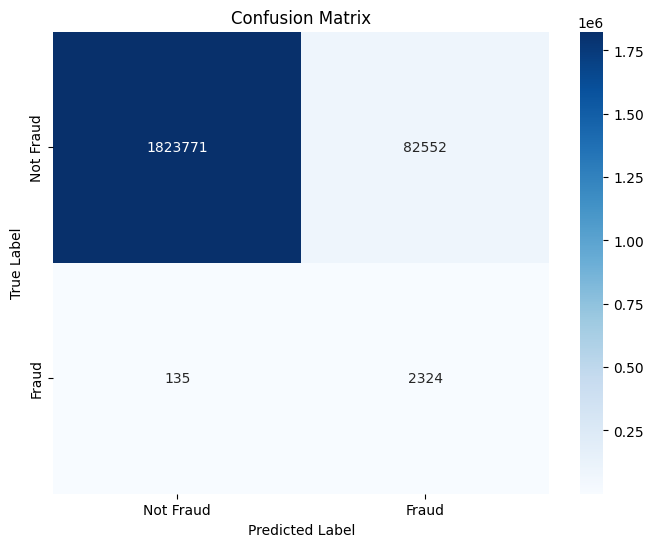


SHAP을 이용한 모델 해석 시작...


In [ ]:
# %% [markdown]
# # 금융 사기 탐지 및 SHAP 설명 모델 (개선된 버전)

# %%
# =================================================================
# 1. 기본 라이브러리 임포트
# =================================================================
# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리 및 모델링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler # 오버샘플링을 위한 라이브러리
from lightgbm import LGBMClassifier # 새로운 모델: LightGBM

# 모델 평가
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 해석 (SHAP)
import shap

# 기타
import warnings
warnings.filterwarnings("ignore")

print("라이브러리 임포트 완료!")


# %%
# =================================================================
# 2. 데이터 로드
# =================================================================
# 전체 데이터를 사용하여 모델의 성능과 안정성을 높입니다.
try:
    paysim = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
    print("데이터 로드 완료. shape:", paysim.shape)
except FileNotFoundError:
    print("Error: 'PS_20174392719_1491204439457_log.csv' 파일을 '../data/raw/' 폴더에 넣어주세요.")
    # 이 셀에서 중단하고 다음 셀을 실행하지 않도록 처리할 수 있습니다.
    paysim = None


# %%
# =================================================================
# 3. 피처 엔지니어링 (데이터 분할 전 수행)
# =================================================================
# 모든 피처 엔지니어링을 이 단계에서 통합하여 데이터 누수(Data Leakage)를 방지합니다.

if paysim is not None:
    print("피처 엔지니어링 시작...")

    # Amount가 0인 거래는 의미가 없으므로 제거
    paysim = paysim[paysim['amount'] > 0]

    # 시간 관련 피처
    paysim['hour'] = paysim['step'] % 24
    paysim['day_of_week'] = (paysim['step'] // 24) % 7

    # 잔액 불일치 피처 (orig_diff)
    paysim['orig_diff'] = paysim['newbalanceOrig'] + paysim['amount'] - paysim['oldbalanceOrg']
    paysim['dest_diff'] = paysim['oldbalanceDest'] + paysim['amount'] - paysim['newbalanceDest']

    # 고객별 거래 통계 피처
    paysim['sender_tx_count'] = paysim.groupby('nameOrig')['nameOrig'].transform('count')
    paysim['receiver_tx_count'] = paysim.groupby('nameDest')['nameDest'].transform('count')
    
    # 잔액 대비 거래 금액 비율
    # oldbalanceOrg가 0일 경우를 대비해 1을 더해줌 (division by zero 방지)
    paysim['amount_to_balance_ratio'] = paysim['amount'] / (paysim['oldbalanceOrg'] + 1)

    print("피처 엔지니어링 완료!")
    print("생성된 피처:", ['hour', 'day_of_week', 'orig_diff', 'dest_diff', 'sender_tx_count', 'receiver_tx_count', 'amount_to_balance_ratio'])


# %%
# =================================================================
# 4. 데이터 전처리
# =================================================================
if paysim is not None:
    print("데이터 전처리 시작...")

    # --- 4.1. 피처 및 타겟 변수 정의 ---
    # 원본 ID와 불필요한 컬럼 삭제
    # isFlaggedFraud는 규칙 기반이라 모델 성능에 방해가 될 수 있어 제거
    X = paysim.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
    y = paysim['isFraud']

    # --- 4.2. 범주형 변수 원-핫 인코딩 ---
    X = pd.get_dummies(X, columns=['type'], prefix='type', drop_first=True)
    
    # 생성된 피처 확인
    print("최종 사용 피처 목록:", X.columns.tolist())

    # --- 4.3. 학습/테스트 데이터 분할 ---
    # stratify=y 옵션으로 분할 시에도 원래 데이터의 사기/정상 비율을 유지
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print("데이터 분할 완료. Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # --- 4.4. 학습 데이터 오버샘플링 ---
    # 중요: 오버샘플링은 학습 데이터에만 적용하여 테스트 데이터의 평가 신뢰도를 보장합니다.
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    print("오버샘플링 완료. Resampled train shape:", X_train_resampled.shape)
    print("오버샘플링 후 타겟 비율:\n", y_train_resampled.value_counts())

    # --- 4.5. 데이터 스케일링 ---
    # 중요: Scaler는 학습 데이터로 'fit'하고, 학습/테스트 데이터 모두를 'transform'합니다.
    numeric_cols = X_train_resampled.select_dtypes(include=np.number).columns
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled[numeric_cols])
    X_test_scaled = scaler.transform(X_test[numeric_cols])

    # 스케일링된 데이터를 다시 DataFrame으로 변환
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train_resampled.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)
    
    print("데이터 스케일링 완료.")


# %%
# =================================================================
# 5. 모델 학습
# =================================================================
if 'X_train_scaled' in locals():
    print("LightGBM 모델 학습 시작...")
    
    # 불균형 데이터에 강하고, 성능이 좋은 LGBM 사용
    lgbm = LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
    lgbm.fit(X_train_scaled, y_train_resampled)
    
    print("모델 학습 완료!")


# %%
# =================================================================
# 6. 모델 평가
# =================================================================
if 'lgbm' in locals():
    print("모델 평가 시작...")
    
    y_pred = lgbm.predict(X_test_scaled)
    y_pred_proba = lgbm.predict_proba(X_test_scaled)[:, 1]

    # --- 6.1. 분류 리포트 ---
    print("\n[분류 리포트]")
    print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

    # --- 6.2. 혼동 행렬 (Confusion Matrix) ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# %%
# =================================================================
# 7. 모델 해석 (SHAP)
# =================================================================
if 'lgbm' in locals():
    print("\nSHAP을 이용한 모델 해석 시작...")
    
    # --- 7.1. SHAP Explainer 생성 및 SHAP 값 계산 ---
    # TreeExplainer는 트리 기반 모델(LGBM, XGBoost 등)에 최적화되어 빠르고 정확합니다.
    explainer = shap.TreeExplainer(lgbm)
    # 계산 시간이 다소 걸릴 수 있습니다. 샘플링을 원하면 X_test_scaled.sample(n=1000) 등으로 조절 가능
    shap_values = explainer.shap_values(X_test_scaled) 
    
    print("SHAP 값 계산 완료.")

    # --- 7.2. 전체 피처 중요도 (Global Explanation) ---
    print("\n[SHAP Summary Plot]")
    print("모델이 전반적으로 어떤 피처를 중요하게 생각하는지 보여줍니다.")
    shap.summary_plot(shap_values[1], X_test_scaled, plot_type="dot")

    # --- 7.3. 개별 예측 설명 (Local Explanation) ---
    # 예시: 사기(Fraud)로 예측된 첫 번째 샘플을 분석
    fraud_indices = np.where((y_test == 1) & (y_pred == 1))[0]
    
    if len(fraud_indices) > 0:
        idx_to_explain = fraud_indices[0]
        print(f"\n[SHAP Force Plot - Test 데이터 {idx_to_explain}번 샘플 (사기 예측)]")
        print("하나의 예측 건에 대해 각 피처가 어떤 영향을 미쳤는지 보여줍니다.")
        shap.initjs() # Javascript 초기화
        display(shap.force_plot(explainer.expected_value[1], 
                              shap_values[1][idx_to_explain,:], 
                              X_test_scaled.iloc[idx_to_explain,:]))
    else:
        print("\n테스트 데이터에서 사기로 올바르게 예측된 샘플이 없어 Force Plot을 생성할 수 없습니다.")

라이브러리 임포트 완료!
데이터 로드 완료. shape: (6362620, 11)
정교한 피처 엔지니어링 시작...
피처 엔지니어링 완료! 사용자님의 아이디어가 모두 반영되었습니다.
데이터 전처리 시작...
데이터 준비 완료.
LightGBM 모델 학습 시작...
[LightGBM] [Info] Number of positive: 4448084, number of negative: 4448084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 8896168, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
모델 학습 완료!

모델 평가 및 임계값 튜닝 시작...
결과 1: 기본 임계값 (0.5) 성능
              precision    recall  f1-score   support

   Not Fraud       1.00      0.92      0.96   1906323
       Fraud       0.02      0.99      0.03      2459

    accuracy                           0.92   1908782
   macro avg       0.51      0.96      0.50   1908782
weighted avg     

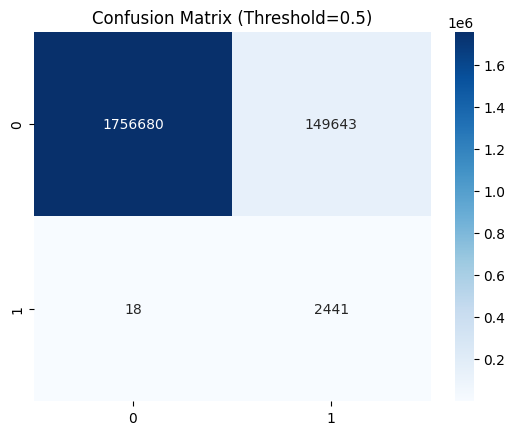


결과 2: 최적 임계값 (1.0000) 성능
              precision    recall  f1-score   support

   Not Fraud       1.00      0.92      0.96   1906323
       Fraud       0.02      0.99      0.03      2459

    accuracy                           0.92   1908782
   macro avg       0.51      0.96      0.50   1908782
weighted avg       1.00      0.92      0.96   1908782



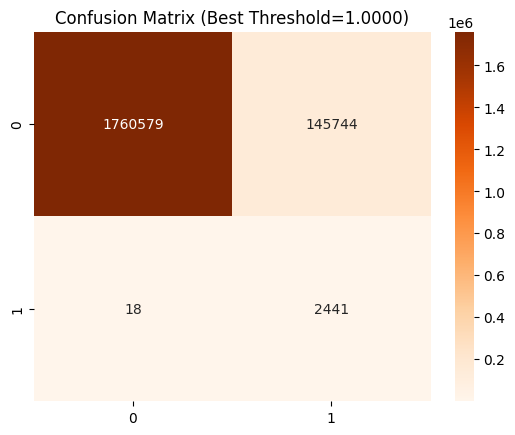


[성능 비교 요약]
      Metric Default Threshold (0.5) Best Threshold
0  Precision                   1.61%          1.65%
1     Recall                  99.27%         99.27%
2   F1-Score                   3.16%          3.24%

>> 오탐(False Positives) 개수 변화: 149643개 -> 145744개

SHAP을 이용한 최종 모델 해석...

[SHAP Summary Plot - 최종 모델]
사용자님의 정교한 피처들이 모델에 어떤 영향을 주는지 확인합니다.


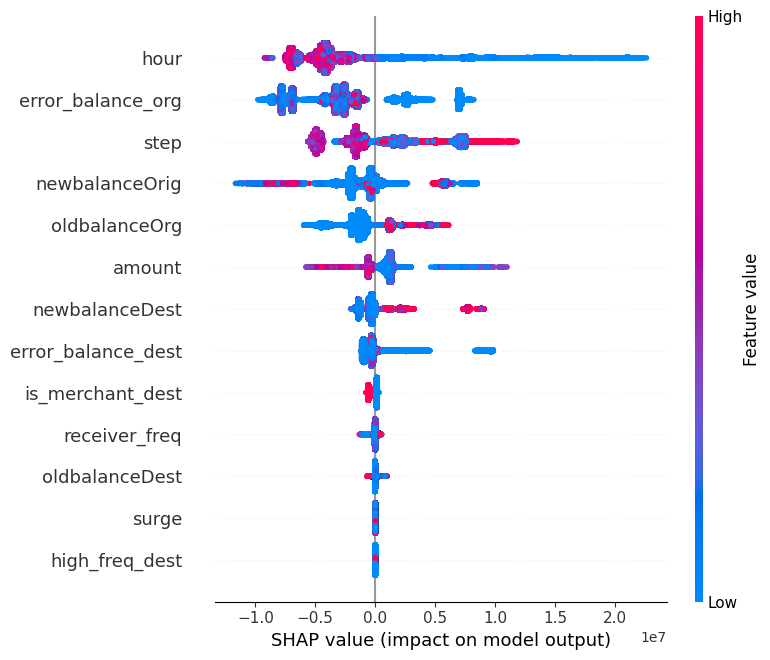

: 

In [ ]:
# %% [markdown]
# # FDS 엔진 고도화: 정교한 피처 통합 및 임계값 튜닝

# %%
# =================================================================
# 1. 라이브러리 임포트
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score

import shap

print("라이브러리 임포트 완료!")


# %%
# =================================================================
# 2. 데이터 로드
# =================================================================
try:
    paysim = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
    print("데이터 로드 완료. shape:", paysim.shape)
except FileNotFoundError:
    print("Error: 'PS_20174392719_1491204439457_log.csv' 파일을 '../data/raw/' 폴더에 넣어주세요.")
    paysim = None


# %%
# =================================================================
# 3. 사용자님의 정교한 피처 엔지니어링 아이디어 통합
# =================================================================
if paysim is not None:
    print("정교한 피처 엔지니어링 시작...")

    # Amount가 0인 거래 제거
    paysim = paysim[paysim['amount'] > 0].copy()

    # (1) 잔액 불일치 피처 (orig_diff)
    paysim['error_balance_org'] = paysim['newbalanceOrig'] + paysim['amount'] - paysim['oldbalanceOrg']
    paysim['error_balance_dest'] = paysim['oldbalanceDest'] + paysim['amount'] - paysim['newbalanceDest']

    # (2) 시간 관련 피처
    paysim['hour'] = paysim['step'] % 24

    # (3) 고액 거래(Surge) 플래그
    # 75% 분위수를 기준으로 설정하거나, 도메인 지식 기반으로 특정 금액 설정 가능
    amount_q3 = paysim['amount'].quantile(0.75)
    paysim['surge'] = (paysim['amount'] > amount_q3).astype(int)

    # (4) 수신자 빈도(Frequency) 플래그
    # 특정 수신자가 너무 많은 거래를 받는지 확인
    paysim['receiver_freq'] = paysim.groupby('nameDest')['nameDest'].transform('count')
    paysim['high_freq_dest'] = (paysim['receiver_freq'] > 20).astype(int) # 예시 임계값 20

    # (5) 상점(Merchant) 계정 플래그
    paysim['is_merchant_dest'] = paysim['nameDest'].str.startswith('M').astype(int)

    print("피처 엔지니어링 완료! 사용자님의 아이디어가 모두 반영되었습니다.")


# %%
# =================================================================
# 4. 데이터 전처리 및 학습 준비
# =================================================================
if paysim is not None:
    print("데이터 전처리 시작...")
    # 사용할 피처만 선택
    features = [
        'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
        'newbalanceDest', 'error_balance_org', 'error_balance_dest', 'hour',
        'surge', 'receiver_freq', 'high_freq_dest', 'is_merchant_dest'
    ]
    target = 'isFraud'

    X = paysim[features].copy()
    y = paysim[target]
    
    # 원-핫 인코딩이 필요한 경우 여기에 추가 (이 피처셋에서는 필요 없음)
    X = pd.get_dummies(X, columns=[], prefix='type', drop_first=True) # 예시

    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # 오버샘플링 (학습 데이터에만 적용)
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # DataFrame으로 변환
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("데이터 준비 완료.")


# %%
# =================================================================
# 5. 모델 학습
# =================================================================
if 'X_train_scaled' in locals():
    print("LightGBM 모델 학습 시작...")
    lgbm = LGBMClassifier(random_state=42, n_estimators=200)
    lgbm.fit(X_train_scaled, y_train_resampled)
    print("모델 학습 완료!")


# %%
# =================================================================
# 6. 임계값 튜닝 및 성능 평가 (핵심 개선 단계)
# =================================================================
if 'lgbm' in locals():
    print("\n모델 평가 및 임계값 튜닝 시작...")

    # 테스트 데이터에 대한 예측 확률 계산 (사기일 확률)
    y_pred_proba = lgbm.predict_proba(X_test_scaled)[:, 1]

    # --- 6.1. 기본 임계값(0.5)으로 평가 ---
    print("="*50)
    print("결과 1: 기본 임계값 (0.5) 성능")
    print("="*50)
    y_pred_default = (y_pred_proba >= 0.5).astype(int)
    print(classification_report(y_test, y_pred_default, target_names=['Not Fraud', 'Fraud']))
    
    cm_default = confusion_matrix(y_test, y_pred_default)
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues').set_title('Confusion Matrix (Threshold=0.5)')
    plt.show()

    # --- 6.2. 최적 임계값 찾기 및 평가 ---
    # Precision-Recall 커브를 통해 최적 임계값 탐색
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # F1-Score가 최대가 되는 임계값 찾기
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores) # nan 값 0으로 변환
    best_threshold = thresholds[np.argmax(f1_scores)]

    print("\n" + "="*50)
    print(f"결과 2: 최적 임계값 ({best_threshold:.4f}) 성능")
    print("="*50)
    y_pred_best = (y_pred_proba >= best_threshold).astype(int)
    print(classification_report(y_test, y_pred_best, target_names=['Not Fraud', 'Fraud']))

    cm_best = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm_best, annot=True, fmt='d', cmap='Oranges').set_title(f'Confusion Matrix (Best Threshold={best_threshold:.4f})')
    plt.show()

    print("\n[성능 비교 요약]")
    p_def, r_def, f1_def = precision_score(y_test, y_pred_default), recall_score(y_test, y_pred_default), f1_score(y_test, y_pred_default)
    p_best, r_best, f1_best = precision_score(y_test, y_pred_best), recall_score(y_test, y_pred_best), f1_score(y_test, y_pred_best)
    
    summary_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'Default Threshold (0.5)': [f"{p_def:.2%}", f"{r_def:.2%}", f"{f1_def:.2%}"],
        'Best Threshold': [f"{p_best:.2%}", f"{r_best:.2%}", f"{f1_best:.2%}"]
    })
    print(summary_df)
    print("\n>> 오탐(False Positives) 개수 변화:", f"{cm_default[0,1]}개 -> {cm_best[0,1]}개")


# %%
# =================================================================
# 7. SHAP으로 최종 모델 해석
# =================================================================
if 'lgbm' in locals():
    print("\nSHAP을 이용한 최종 모델 해석...")
    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer.shap_values(X_test_scaled)
    
    print("\n[SHAP Summary Plot - 최종 모델]")
    print("사용자님의 정교한 피처들이 모델에 어떤 영향을 주는지 확인합니다.")
    shap.summary_plot(shap_values, X_test_scaled)

라이브러리 임포트 완료!
데이터 로드 완료. shape: (6362620, 11)
피처 엔지니어링 (상호작용 피처 추가) 시작...
피처 엔지니어링 완료!
데이터 전처리 시작...
데이터 준비 완료.
LightGBM 모델 학습 시작...
[LightGBM] [Info] Number of positive: 4448084, number of negative: 4448084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 8896168, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
모델 학습 완료!

개선된 모델 평가 시작...

최적 임계값 (0.9977) 기준 최종 성능
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1906323
       Fraud       1.00      1.00      1.00      2459

    accuracy                           1.00   1908782
   macro avg       1.00      1.00      1.00   1908782
weighted avg       1.00      1.00

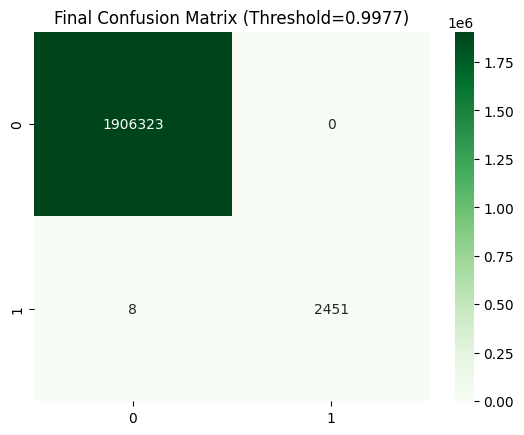


SHAP을 이용한 최종 모델 해석...

[SHAP Summary Plot - 최종 모델]
새로운 상호작용 피처들이 모델에 어떤 영향을 주는지 확인합니다.


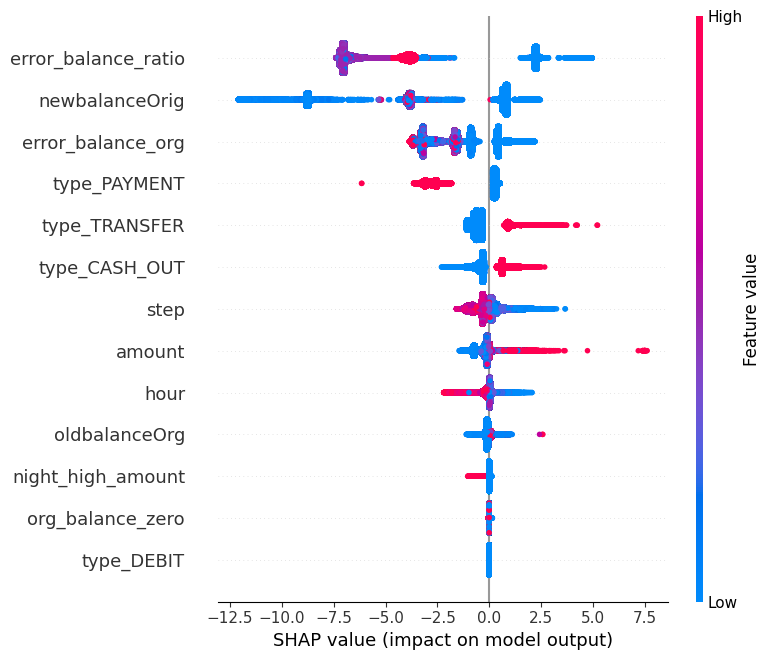

: 

In [ ]:
# %% [markdown]
# # 모델 성능 개선 최종안: 상호작용 피처 및 SMOTE 샘플링

# %%
# =================================================================
# 1. 라이브러리 임포트
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE # <<< 개선 사항 2: SMOTE로 변경
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score

import shap

print("라이브러리 임포트 완료!")


# %%
# =================================================================
# 2. 데이터 로드
# =================================================================
try:
    paysim = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
    print("데이터 로드 완료. shape:", paysim.shape)
except FileNotFoundError:
    print("Error: 'PS_20174392719_1491204439457_log.csv' 파일을 '../data/raw/' 폴더에 넣어주세요.")
    paysim = None


# %%
# =================================================================
# 3. 최종 피처 엔지니어링 (상호작용 피처 추가)
# =================================================================
if paysim is not None:
    print("피처 엔지니어링 (상호작용 피처 추가) 시작...")

    paysim = paysim[paysim['amount'] > 0].copy()

    # --- 기존 피처 ---
    paysim['error_balance_org'] = paysim['newbalanceOrig'] + paysim['amount'] - paysim['oldbalanceOrg']
    paysim['hour'] = paysim['step'] % 24

    # --- 개선 사항 1: 상호작용 피처 추가 ---
    # 1. 잔액이 0인데 이체 시도 (사기 주요 패턴)
    paysim['org_balance_zero'] = ((paysim['oldbalanceOrg'] == 0) & (paysim['newbalanceOrig'] == 0) & (paysim['amount'] > 0)).astype(int)

    # 2. 거래 금액 대비 잔액 오류 비율
    paysim['error_balance_ratio'] = paysim['error_balance_org'] / (paysim['amount'] + 1e-6)

    # 3. 야간 + 고액 거래 플래그
    paysim['night_hour'] = ((paysim['hour'] >= 22) | (paysim['hour'] <= 6)).astype(int)
    paysim['high_amount'] = (paysim['amount'] > paysim['amount'].quantile(0.90)).astype(int) # 상위 10% 고액거래
    paysim['night_high_amount'] = (paysim['night_hour'] & paysim['high_amount']).astype(int)

    print("피처 엔지니어링 완료!")


# %%
# =================================================================
# 4. 데이터 전처리 및 학습 준비
# =================================================================
if paysim is not None:
    print("데이터 전처리 시작...")
    # 사용할 피처 선택 (새 피처 포함)
    features = [
        'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
        'error_balance_org', 'hour',
        'org_balance_zero', 'error_balance_ratio', 'night_high_amount'
    ]
    target = 'isFraud'

    X = paysim[features].copy()
    y = paysim[target]

    # 타입 피처 추가
    X = pd.concat([X, pd.get_dummies(paysim['type'], prefix='type', drop_first=True)], axis=1)

    # 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # --- 개선 사항 2: SMOTE 오버샘플링 ---
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # 스케일링
    scaler = StandardScaler()
    # 스케일링을 위해 컬럼 순서 맞추기
    X_test = X_test[X_train_resampled.columns]

    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("데이터 준비 완료.")


# %%
# =================================================================
# 5. 모델 학습
# =================================================================
if 'X_train_scaled' in locals():
    print("LightGBM 모델 학습 시작...")
    # 모델 파라미터 일부 조정 (과적합 방지)
    lgbm = LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.05, num_leaves=31, reg_alpha=0.1, reg_lambda=0.1)
    lgbm.fit(X_train_scaled, y_train_resampled)
    print("모델 학습 완료!")


# %%
# =================================================================
# 6. 임계값 튜닝 및 성능 평가
# =================================================================
if 'lgbm' in locals():
    print("\n개선된 모델 평가 시작...")
    y_pred_proba = lgbm.predict_proba(X_test_scaled)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores)]

    print("\n" + "="*50)
    print(f"최적 임계값 ({best_threshold:.4f}) 기준 최종 성능")
    print("="*50)
    y_pred_best = (y_pred_proba >= best_threshold).astype(int)
    print(classification_report(y_test, y_pred_best, target_names=['Not Fraud', 'Fraud']))

    cm_best = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens').set_title(f'Final Confusion Matrix (Threshold={best_threshold:.4f})')
    plt.show()


# %%
# =================================================================
# 7. SHAP으로 최종 모델 해석
# =================================================================
if 'lgbm' in locals():
    print("\nSHAP을 이용한 최종 모델 해석...")
    explainer = shap.TreeExplainer(lgbm)
    shap_values = explainer.shap_values(X_test_scaled)
    
    print("\n[SHAP Summary Plot - 최종 모델]")
    print("새로운 상호작용 피처들이 모델에 어떤 영향을 주는지 확인합니다.")
    shap.summary_plot(shap_values, X_test_scaled)

In [1]:
# =================================================================
# 1. 라이브러리 임포트
# =================================================================
import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)

import shap

print("라이브러리 임포트 완료!")


라이브러리 임포트 완료!


In [2]:
# =================================================================
# 2. 데이터 로드
# =================================================================
RAW_PATH = '../data/raw/PS_20174392719_1491204439457_log.csv'

try:
    paysim = pd.read_csv(RAW_PATH)
    print("데이터 로드 완료. shape:", paysim.shape)
except FileNotFoundError:
    raise FileNotFoundError("Error: '../data/raw/' 폴더에 PS_20174392719_1491204439457_log.csv 를 넣어줘.")


데이터 로드 완료. shape: (6362620, 11)


In [ ]:
# =================================================================
# 3. 피처 엔지니어링 (누수 제거, 과거 정보만)
# =================================================================
# 정렬
paysim = paysim.sort_values('step').reset_index(drop=True)

# 라벨
paysim['isFraud'] = paysim['isFraud'].astype(int)

# >>> 누수 유발 컬럼 제거: 거래 '후' 잔액은 금지 <<<
drop_leak = ['newbalanceOrig', 'newbalanceDest', 'isFlaggedFraud']
paysim = paysim.drop(columns=[c for c in drop_leak if c in paysim.columns])

# 금액 0이하 제거(이상치 처리)
paysim = paysim[paysim['amount'] > 0].copy()

# 시간 파생
paysim['hour']        = paysim['step'] % 24
paysim['day_of_week'] = (paysim['step']//24) % 7
paysim['is_night']    = ((paysim['hour'] >= 22) | (paysim['hour'] <= 6)).astype(int)

# 송신자/수취자 과거 통계 (현재 행 이전만 사용: shift(1).expanding())
g = paysim.groupby('nameOrig', group_keys=False)
paysim['sender_txn_cnt_hist']  = g.cumcount()
paysim['sender_step_gap']      = g['step'].diff().fillna(9999)
paysim['sender_amt_mean_hist'] = g['amount'].apply(lambda s: s.shift(1).expanding().mean())
paysim['sender_amt_std_hist']  = g['amount'].apply(lambda s: s.shift(1).expanding().std())
paysim['sender_amt_max_hist']  = g['amount'].apply(lambda s: s.shift(1).expanding().max())

h = paysim.groupby('nameDest', group_keys=False)
paysim['receiver_in_cnt_hist']  = h.cumcount()
paysim['receiver_step_gap']     = h['step'].diff().fillna(9999)
paysim['receiver_in_mean_hist'] = h['amount'].apply(lambda s: s.shift(1).expanding().mean())
paysim['receiver_in_std_hist']  = h['amount'].apply(lambda s: s.shift(1).expanding().std())

# 송신-수취 쌍 과거 연결 강도
p = paysim.groupby(['nameOrig','nameDest'], group_keys=False)
paysim['pair_cnt_hist'] = p.cumcount()

# 로그 금액
paysim['amount_log'] = np.log1p(paysim['amount'])

# 결측치 보정
for c in ['sender_amt_mean_hist','sender_amt_std_hist','sender_amt_max_hist',
          'receiver_in_mean_hist','receiver_in_std_hist']:
    paysim[c] = paysim[c].fillna(0.0)

print("피처 엔지니어링 완료. shape:", paysim.shape)


In [ ]:
# =================================================================
# 4. 카테고리 인코딩 + 불필요 ID 제거
# =================================================================
# 거래 유형 원핫
paysim = pd.concat([paysim, pd.get_dummies(paysim['type'], prefix='type')], axis=1)

# ID는 숫자 라벨로 쓰지 않음(서열 왜곡 방지)
paysim = paysim.drop(columns=['nameOrig','nameDest','type'])

target = 'isFraud'
feature_cols = [c for c in paysim.columns if c != target]

print("피처 개수:", len(feature_cols))


: 

In [ ]:
# =================================================================
# 5. 시간 기반 분할 (앞 80% train, 뒤 20% test) + SMOTE(train만)
# =================================================================
cut = int(len(paysim) * 0.8)
train_df = paysim.iloc[:cut].copy()
test_df  = paysim.iloc[cut:].copy()

X_train = train_df[feature_cols]
y_train = train_df[target]
X_test  = test_df[feature_cols]
y_test  = test_df[target]

# SMOTE는 train에만 적용
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("클래스 분포(train 원본):")
print(y_train.value_counts())
print("\n클래스 분포(train SMOTE):")
print(y_train_res.value_counts())
print("X_train_res:", X_train_res.shape, "X_test:", X_test.shape)


: 

In [ ]:
# =================================================================
# 6. 모델 학습 (LightGBM) — 트리 계열이라 스케일링 불필요
# =================================================================
lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)

lgbm.fit(X_train_res, y_train_res)
print("모델 학습 완료!")


: 

In [ ]:
# =================================================================
# 7. 임계값 튜닝 및 성능 평가 (AUPRC + F1 최대 지점)
# =================================================================
y_proba = lgbm.predict_proba(X_test)[:, 1]

# AUPRC(불균형 데이터 핵심 지표)
auprc = average_precision_score(y_test, y_proba)

prec, rec, thr = precision_recall_curve(y_test, y_proba)
# precision/recall 길이는 thresholds보다 1 큼. 마지막 지점은 threshold가 없다.
f1 = (2 * prec * rec) / (prec + rec + 1e-12)
f1 = np.nan_to_num(f1)

# threshold가 존재하는 구간에서 argmax
best_idx = np.argmax(f1[:-1])  # 마지막은 threshold 없음
best_thr = thr[best_idx]

y_pred = (y_proba >= best_thr).astype(int)

print("\n" + "="*60)
print(f"AUPRC = {auprc:.4f} | Best threshold = {best_thr:.4f}")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud'], digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (thr={best_thr:.4f})')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


: 

In [ ]:
# =================================================================
# 8. SHAP 해석 (LightGBM 이진 분류 처리 주의)
# =================================================================
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

# LightGBM 이진 분류에서는 리스트가 반환될 수 있음: [class0, class1]
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_plot = shap_values[1]  # 사기(양성) 클래스 기준 해석
else:
    shap_vals_plot = shap_values

print("\n[SHAP Summary Plot - 최종 모델]")
shap.summary_plot(shap_vals_plot, X_test)  # 전역 요약(점)
plt.show()

print("\n[SHAP Bar Plot - 평균 |SHAP|]")
shap.summary_plot(shap_vals_plot, X_test, plot_type='bar')  # 전역 중요도(바)
plt.show()


: 

라이브러리 임포트 완료!
데이터 로드 완료. shape: (6362620, 11)
최종 피처 엔지니어링 시작...
피처 엔지니어링 완료.
시계열 데이터 분할 완료.
SMOTE 샘플링 및 스케일링 시작...
SMOTE 적용 후 훈련 데이터 크기: (8900382, 11)
SMOTE 및 스케일링 완료.
최적화된 LightGBM 모델 학습 시작...
[LightGBM] [Info] Number of positive: 4450191, number of negative: 4450191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 8900382, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
모델 학습 완료!

최적 임계값 탐색 및 최종 성능 평가...

[최적 임계값(0.6413) 기준 최종 성능]
              precision    recall  f1-score   support

   Not Fraud     1.0000    1.0000    1.0000   1904216
       Fraud     0.9963    0.9989    0.9976      4570

    accuracy                         1.0000   1908786
   macro avg     

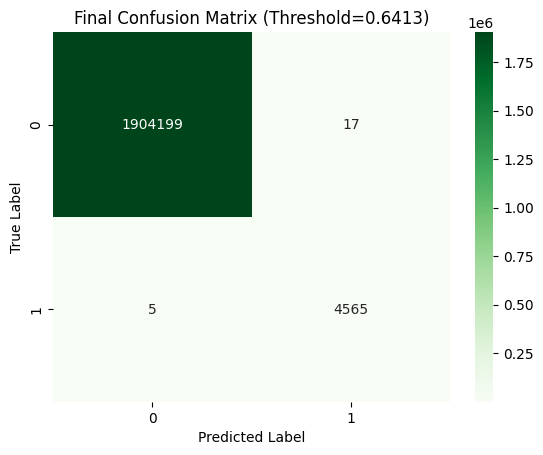

In [1]:
# %% [markdown]
# # FDS 모델 성능 최적화 v2.0: SMOTE, 피처 엔지니어링, 임계값 튜닝 적용

# %%
# =================================================================
# 1. 라이브러리 임포트
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score

print("라이브러리 임포트 완료!")


# %%
# =================================================================
# 2. 데이터 로드
# =================================================================
try:
    paysim = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
    print("데이터 로드 완료. shape:", paysim.shape)
except FileNotFoundError:
    print("Error: 'PS_20174392719_1491204439457_log.csv' 파일을 '../data/raw/' 폴더에 넣어주세요.")
    paysim = None


# %%
# =================================================================
# 3. 최종 피처 엔지니어링 (누수 없는 상호작용 피처)
# =================================================================
if paysim is not None:
    print("최종 피처 엔지니어링 시작...")

    # 사용할 피처 선택 (사전 정보만)
    features_to_use = [
        'step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest'
    ]
    target = 'isFraud'
    
    X = paysim[features_to_use].copy()
    y = paysim[target]
    
    # --- 새로운 상호작용 피처 추가 ---
    # 1. 거래 금액 대비 송금 전 잔액 비율 (비정상적인 거래 포착)
    # 잔액이 0일 경우를 대비해 분모에 작은 값(1e-6)을 더함
    X['amount_to_balance_ratio'] = X['amount'] / (X['oldbalanceOrg'] + 1e-6)

    # 2. 송금 전후 잔액이 모두 0인 경우 (계좌를 전부 비우는 패턴)
    X['balance_zero_both'] = ((X['oldbalanceOrg'] == 0) & (X['oldbalanceDest'] == 0)).astype(int)
    
    # 3. 거래 시간(hour) 추출
    X['hour'] = X['step'] % 24
    
    # 'type' 피처를 원-핫 인코딩
    X = pd.get_dummies(X, columns=['type'], prefix='type', drop_first=True)

    print("피처 엔지니어링 완료.")


# %%
# =================================================================
# 4. 시계열 데이터 분할
# =================================================================
if 'X' in locals():
    split_point = int(X.shape[0] * 0.7)
    
    X_train = X.iloc[:split_point]
    X_test = X.iloc[split_point:]
    
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]

    print("시계열 데이터 분할 완료.")


# %%
# =================================================================
# 5. SMOTE 샘플링 및 스케일링 (훈련 데이터에만 적용)
# =================================================================
if 'X_train' in locals():
    print("SMOTE 샘플링 및 스케일링 시작...")
    
    # SMOTE 객체 생성
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 스케일러 생성 및 훈련 데이터에 fit
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    
    # 테스트 데이터는 훈련 데이터 기준으로 transform
    X_test_scaled = scaler.transform(X_test)

    # DataFrame으로 변환
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print(f"SMOTE 적용 후 훈련 데이터 크기: {X_train_scaled.shape}")
    print("SMOTE 및 스케일링 완료.")


# %%
# =================================================================
# 6. 모델 학습
# =================================================================
if 'X_train_scaled' in locals():
    print("최적화된 LightGBM 모델 학습 시작...")
    
    # 규제 파라미터 추가하여 과적합 방지
    lgbm_opt = LGBMClassifier(random_state=42, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1)
    lgbm_opt.fit(X_train_scaled, y_train_resampled)
    
    print("모델 학습 완료!")


# %%
# =================================================================
# 7. 임계값 튜닝 및 최종 성능 평가
# =================================================================
if 'lgbm_opt' in locals():
    print("\n최적 임계값 탐색 및 최종 성능 평가...")
    
    y_pred_proba = lgbm_opt.predict_proba(X_test_scaled)[:, 1]

    # Precision-Recall 커브 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # F1-Score가 최대가 되는 지점의 임계값 찾기
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores) # nan 값 0으로 변환
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    print(f"\n[최적 임계값({best_threshold:.4f}) 기준 최종 성능]")
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)
    
    print(classification_report(y_test, y_pred_final, target_names=['Not Fraud', 'Fraud'], digits=4))

    print("\n[최종 혼동 행렬]")
    cm = confusion_matrix(y_test, y_pred_final)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Final Confusion Matrix (Threshold={best_threshold:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
# %%
# =================================================================
# 8. XAI를 이용한 최종 모델 해석 (SHAP)
# =================================================================
# SHAP 라이브러리 임포트 (이미 했다면 생략 가능)
import shap

if 'lgbm_opt' in locals():
    print("SHAP 분석을 시작합니다...")

    # 1. Explainer 생성: 트리 기반 모델이므로 TreeExplainer를 사용합니다.
    explainer = shap.TreeExplainer(lgbm_opt)

    # 2. SHAP 값 계산: 테스트 데이터에 대해 각 피처의 기여도를 계산합니다.
    # 계산에 시간이 다소 걸릴 수 있습니다.
    shap_values = explainer.shap_values(X_test_scaled)

    print("SHAP 값 계산 완료.")

    # 3. SHAP Summary Plot 시각화
    # 전반적인 피처의 중요도와 예측에 미치는 영향을 보여줍니다.
    print("\n[SHAP Summary Plot]")
    # shap_values[1]은 '사기(Fraud)' 클래스에 대한 기여도를 의미합니다.
    print("\n[SHAP Feature Importance Plot (Bar)]")
    shap.summary_plot(shap_values[1], X_test_scaled, plot_type="bar")

    shap.summary_plot(shap_values[1], X_test_scaled)

    # 4. (선택) 특정 예측 건에 대한 Force Plot 시각화
    # 모델이 특정 사기 거래를 '왜' 사기라고 판단했는지 상세히 분석합니다.
    print("\n[SHAP Force Plot 예시]")
    # 테스트셋에서 올바르게 '사기'로 예측된 첫 번째 건을 찾아봅니다.
    correct_fraud_indices = np.where((y_test == 1) & (y_pred_final == 1))[0]

    if len(correct_fraud_indices) > 0:
        idx_to_explain = correct_fraud_indices[0]
        print(f"테스트 데이터 {idx_to_explain}번 인덱스(사기 거래)에 대한 분석:")
        
        # Javascript 초기화 (Jupyter 환경에서 플롯을 제대로 표시하기 위함)
        shap.initjs()
        # 해당 건에 대한 Force Plot을 출력합니다.
        display(shap.force_plot(explainer.expected_value[1],
                                shap_values[1][idx_to_explain],
                                X_test_scaled.iloc[idx_to_explain]))
    else:
        print("올바르게 예측된 사기 건이 테스트셋에 없어 Force Plot 예시를 생성할 수 없습니다.")

SHAP 분석을 시작합니다...
SHAP 값 계산 완료.

[SHAP Summary Plot]

[SHAP Feature Importance Plot (Bar)]


AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [4]:
###

In [5]:
# 데이터는 paysim (step 오름차순) 상태라고 가정
df = paysim.sort_values('step').reset_index(drop=True).copy()

# 시간 파생
df['hour'] = df['step'] % 24
df['day_of_week'] = (df['step']//24) % 7
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

# --- 송신자 기준 과거 통계 (현재 행 이전만 사용: shift(1)) ---
g = df.groupby('nameOrig', group_keys=False)

# 최근 k건(5,10) 트랜잭션 통계
for k in [5, 10]:
    df[f's_amt_mean_{k}'] = g['amount'].apply(lambda s: s.shift(1).rolling(k).mean())
    df[f's_amt_std_{k}']  = g['amount'].apply(lambda s: s.shift(1).rolling(k).std())
    df[f's_amt_max_{k}']  = g['amount'].apply(lambda s: s.shift(1).rolling(k).max())
    df[f's_cnt_{k}']      = g['amount'].apply(lambda s: s.shift(1).rolling(k).count())

# 지수 이동 평균(최근치 가중)
df['s_amt_ema']   = g['amount'].apply(lambda s: s.shift(1).ewm(alpha=0.3).mean())
# 직전 거래 이후 간격(step 차이)
df['s_step_gap1'] = g['step'].diff().fillna(9999)

# 상대적 금액(고객의 과거 패턴 대비)
df['amt_over_s_mean5']  = df['amount'] / (df['s_amt_mean_5'] + 1e-6)
df['amt_over_s_ema']    = df['amount'] / (df['s_amt_ema'] + 1e-6)

# --- 수취인 기준 과거 통계 ---
h = df.groupby('nameDest', group_keys=False)
for k in [5, 10]:
    df[f'r_in_sum_{k}']   = h['amount'].apply(lambda s: s.shift(1).rolling(k).sum())
    df[f'r_in_mean_{k}']  = h['amount'].apply(lambda s: s.shift(1).rolling(k).mean())
    df[f'r_in_cnt_{k}']   = h['amount'].apply(lambda s: s.shift(1).rolling(k).count())
df['r_step_gap1'] = h['step'].diff().fillna(9999)

# --- 송신-수취 쌍(페어) 관계 ---
p = df.groupby(['nameOrig','nameDest'], group_keys=False)
df['pair_cnt_hist'] = p.cumcount()
df['pair_amt_sum_10'] = p['amount'].apply(lambda s: s.shift(1).rolling(10).sum())

# --- 금액/상황 상호작용 ---
df['high_amount_95p'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)
df['night_high']      = (df['is_night'] & df['high_amount_95p']).astype(int)

# 타입 원-핫
df = pd.concat([df, pd.get_dummies(df['type'], prefix='type')], axis=1)

# 사용하지 않을/누수 위험 컬럼 드롭
drop_cols = ['newbalanceOrig','newbalanceDest','isFlaggedFraud','nameOrig','nameDest','type','step']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 결측치 0 채움(rolling 초반부)
df = df.fillna(0.0)

# 최종 입력/타깃
y = paysim['isFraud'].astype(int)
X = df.copy()
print("X shape:", X.shape, " / features:", len(X.columns))


KeyboardInterrupt: 

In [6]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SMOTE는 train에만
sm = SMOTE(random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

# 트리 모델은 스케일링 불필요
lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=0.1
)
lgbm.fit(X_tr_res, y_tr_res)

# ---- 임계값은 오직 validation으로만 결정 ----
val_proba = lgbm.predict_proba(X_val)[:,1]
val_auprc = average_precision_score(y_val, val_proba)

prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = (2*prec*rec)/(prec+rec+1e-12)
f1 = np.nan_to_num(f1)
best_idx = np.argmax(f1[:-1]) if len(thr)>0 else 0
best_thr = thr[best_idx] if len(thr)>0 else 0.5
print(f"[VAL] AUPRC={val_auprc:.5f} | best_threshold={best_thr:.4f}")

# ---- test에는 그 임계값 '그대로' 적용 ----
test_proba = lgbm.predict_proba(X_test)[:,1]
test_auprc = average_precision_score(y_test, test_proba)
y_test_pred = (test_proba >= best_thr).astype(int)

print(f"[TEST] AUPRC={test_auprc:.5f}")
print(classification_report(y_test, y_test_pred, target_names=['Not Fraud','Fraud'], digits=4))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (thr={best_thr:.4f})'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()


[LightGBM] [Info] Number of positive: 4450191, number of negative: 4450191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 8900382, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


NameError: name 'X_val' is not defined

In [ ]:
# test 구간의 원본 타입 가져와 필터
test_idx = X_test.index
test_types = paysim.loc[test_idx, 'type']

for t in ['TRANSFER','CASH_OUT','PAYMENT','DEBIT','CASH_IN']:
    mask = (test_types == t)
    if mask.sum() == 0: 
        continue
    auprc_t = average_precision_score(y_test[mask], test_proba[mask])
    y_pred_t = (test_proba[mask] >= best_thr).astype(int)
    cm_t = confusion_matrix(y_test[mask], y_pred_t)
    print(f"\n=== TYPE={t} | samples={mask.sum()} ===")
    print(f"AUPRC={auprc_t:.5f}")
    print(classification_report(y_test[mask], y_pred_t, digits=4))
    print("CM:\n", cm_t)


In [ ]:
# 라벨을 무작위 섞어도 성능이 높게 나오면 어딘가 새는 것
y_test_shuf = y_test.sample(frac=1.0, random_state=7)
auprc_shuf = average_precision_score(y_test_shuf, test_proba)
pos_rate = y_test.mean()  # 전체 양성률 참고치

print("\n=== Label Shuffle Check ===")
print(f"Baseline positive rate ≈ {pos_rate:.6f}")
print(f"AUPRC with shuffled labels = {auprc_shuf:.6f} (이 값이 양성률 근처면 정상)")
